Use Keras models with seq2seq neural networks to build a better translation tool.

**Pre-processing**

In [3]:
import numpy as np
import re

In [4]:
# Importing our translations
# for example: "spa.txt" or "spa-eng/spa.txt"
data_path = "deu-eng/deu.txt"

# Defining lines as a list of each line
with open(data_path, 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')

In [5]:
# Create empty lists to hold sentences
input_docs = []
target_docs = []
# Create empty vocabulary sets
input_tokens = set()
target_tokens = set()

# Adjust the number of lines so that preprocessing doesn't take too long
for line in lines[:7500]:
    # Input and target sentences are separated by tabs
    input_doc, target_doc = line.split('\t')[:2]
    # Append each input sentence to input_docs
    input_docs.append(input_doc)
    # Separate words from punctuation
    target_doc = " ".join(re.findall(r"[\w']+|[^\s\w]", target_doc))
    # Redefine target_doc below and append it to target_docs:
    target_doc = '<START> ' + target_doc + ' <END>'
    target_docs.append(target_doc)

    # Split up each sentence into words and add each unique word to our vocabulary set
    for token in re.findall(r"[\w']+|[^\s\w]", input_doc):
    # print(token)
        if token not in input_tokens:
            input_tokens.add(token)
    for token in target_doc.split():
    # print(token)
        if token not in target_tokens:
            target_tokens.add(token)

input_tokens = sorted(list(input_tokens))
target_tokens = sorted(list(target_tokens))

# Create num_encoder_tokens and num_decoder_tokens:
# Length of the input tokens set
num_encoder_tokens = len(input_tokens)
# Length of the target tokens set
num_decoder_tokens = len(target_tokens)

max_encoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", input_doc)) for input_doc in input_docs])
max_decoder_seq_length = max([len(re.findall(r"[\w']+|[^\s\w]", target_doc)) for target_doc in target_docs])

print('Number of samples:', len(input_docs))
print('Number of unique input tokens:', num_encoder_tokens)
print('Number of unique output tokens:', num_decoder_tokens)
print('Max sequence length for inputs:', max_encoder_seq_length)
print('Max sequence length for outputs:', max_decoder_seq_length)

# Define dictionary for input vocabulary
input_features_dict = dict([(token, i) for i, token in enumerate(input_tokens)])
# Repeat for target vocabulary
target_features_dict = dict([(token, i) for i, token in enumerate(target_tokens)])

# Reverse lookup token index to decode sequences back to something readable
# i.e. just swaps the keys and values
reverse_input_features_dict = dict((i, token) for token, i in input_features_dict.items())
# Repeat for target
reverse_target_features_dict = dict((i, token) for token, i in target_features_dict.items())

# Create an empty matrix for the data we'll pass into the encoder
encoder_input_data = np.zeros((len(input_docs), max_encoder_seq_length, num_encoder_tokens), dtype='float32')
print("\nHere's the first item in the encoder input matrix:\n", encoder_input_data[0], 
      "\n\nThe number of columns should match the number of unique input tokens and the number of rows should match the maximum sequence length for input sentences.")
# Create an empty matrix for the data we'll pass into the decoder
decoder_input_data = np.zeros((len(input_docs), max_decoder_seq_length, num_decoder_tokens), dtype='float32')
# Create an empty matrix for the data we expect the decoder to produce
decoder_target_data = np.zeros((len(input_docs), max_decoder_seq_length, num_decoder_tokens), dtype='float32')

for line, (input_doc, target_doc) in enumerate(zip(input_docs, target_docs)):
    for timestep, token in enumerate(re.findall(r"[\w']+|[^\s\w]", input_doc)):
        # print("Encoder input timestep & token: ", timestep, token)
        # print(input_features_dict[token])
        # Assign 1. for the current line, timestep, & word in encoder_input_data:
        encoder_input_data[line, timestep, input_features_dict[token]] = 1.

    for timestep, token in enumerate(target_doc.split()):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        # print("Decoder input timestep & token:", timestep, token)
        # # Assign 1. for the current line, timestep, & word in decoder_input_data:
        decoder_input_data[line, timestep, target_features_dict[token]] = 1.
        if timestep > 0:
            # # decoder target is ahead by 1 timestep and doesn't include the start token
            # print("Decoder target timestep:", timestep)
            # Assign 1. for the current line, timestep, & word in decoder_target_data:
            decoder_target_data[line, timestep - 1, target_features_dict[token]] = 1.

Number of samples: 7500
Number of unique input tokens: 1997
Number of unique output tokens: 3296
Max sequence length for inputs: 8
Max sequence length for outputs: 15

Here's the first item in the encoder input matrix:
 [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] 

The number of columns should match the number of unique input tokens and the number of rows should match the maximum sequence length for input sentences.


In [6]:
print(list(input_features_dict.keys())[:50])
print(reverse_target_features_dict[50])
print(len(input_tokens))

['!', '"', '$', '%', ',', '.', '00', '10', '15', '17', '18', '19', '2', '3', '30', '300', '45', '5', '50', '7', '8', '9', '99', ':', '?', 'A', 'Abandon', 'Add', 'Aim', 'Air', 'All', 'Am', 'Answer', 'Any', 'Anybody', 'Anyone', 'Anything', 'Arabs', 'Are', 'Asian', 'Ask', 'Attack', 'Austrian', 'Awesome', 'Back', 'Baking', 'Be', 'Beat', 'Beef', "Beer's"]
Antwortet
1997


**Training Model**

In [7]:
# from preprocessing import num_encoder_tokens, num_decoder_tokens, decoder_target_data, encoder_input_data, decoder_input_data, decoder_target_data
from tensorflow import keras
from keras.layers import Input, LSTM, Dense
from keras.models import Model

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

2023-04-13 12:01:38.127147: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-13 12:01:38.127173: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [11]:
# Choose a latent dimensionality. Keras's documentation uses 256, but can be adjusted as necessary.
latent_dim = 256

# Choose a batch size and a larger number of epochs:
# batch size determines the number of sentences used at a time for training
batch_size = 32
# keras' default is 100. More epochs = better model but also a longer training time
epochs = 500

In [12]:
# Encoder training setup
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder_lstm = LSTM(latent_dim, return_state=True)
# retrieve the outputs and states
encoder_outputs, state_hidden, state_cell = encoder_lstm(encoder_inputs)
encoder_states = [state_hidden, state_cell]

# Decoder training setup:
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
# retrieve the LSTM outputs and states
decoder_outputs, decoder_state_hidden, decoder_state_cell = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
# filter outputs through the dense layer
decoder_outputs = decoder_dense(decoder_outputs)

# Build the training model:
training_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

print("Model summary:\n")
training_model.summary()
print("\n\n")

Model summary:

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None, 1997)  0           []                               
                                ]                                                                 
                                                                                                  
 input_4 (InputLayer)           [(None, None, 3296)  0           []                               
                                ]                                                                 
                                                                                                  
 lstm_2 (LSTM)                  [(None, 256),        2308096     ['input_3[0][0]']                
                                 (None, 256),                               

In [13]:
# Compile the model:
training_model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

print("Training the model:\n")
# Train the model:
training_model.fit([encoder_input_data, decoder_input_data], decoder_target_data, batch_size = batch_size, epochs = epochs, validation_split = 0.2)

training_model.save('training_model.h5')

Training the model:

Epoch 1/500
188/188 [==============================] - 23s 108ms/step - loss: 1.6974 - accuracy: 0.0938 - val_loss: 1.8322 - val_accuracy: 0.1083
Epoch 2/500
188/188 [==============================] - 19s 104ms/step - loss: 1.5562 - accuracy: 0.1133 - val_loss: 1.7892 - val_accuracy: 0.1332
Epoch 3/500
188/188 [==============================] - 19s 104ms/step - loss: 1.4700 - accuracy: 0.1252 - val_loss: 1.7726 - val_accuracy: 0.1367
Epoch 4/500
188/188 [==============================] - 20s 104ms/step - loss: 1.4125 - accuracy: 0.1295 - val_loss: 1.7319 - val_accuracy: 0.1299
Epoch 5/500
188/188 [==============================] - 20s 105ms/step - loss: 1.3706 - accuracy: 0.1332 - val_loss: 1.7287 - val_accuracy: 0.1341
Epoch 6/500
188/188 [==============================] - 20s 104ms/step - loss: 1.3348 - accuracy: 0.1390 - val_loss: 1.7045 - val_accuracy: 0.1368
Epoch 7/500
188/188 [==============================] - 20s 104ms/step - loss: 1.3034 - accuracy: 0.1421

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



188/188 [==============================] - 20s 105ms/step - loss: 0.4172 - accuracy: 0.2735 - val_loss: 1.6609 - val_accuracy: 0.2254
Epoch 60/500
188/188 [==============================] - 20s 104ms/step - loss: 0.4104 - accuracy: 0.2743 - val_loss: 1.6692 - val_accuracy: 0.2250
Epoch 61/500
188/188 [==============================] - 20s 105ms/step - loss: 0.4029 - accuracy: 0.2756 - val_loss: 1.6898 - val_accuracy: 0.2272
Epoch 62/500
188/188 [==============================] - 20s 106ms/step - loss: 0.3979 - accuracy: 0.2751 - val_loss: 1.6822 - val_accuracy: 0.2247
Epoch 63/500
188/188 [==============================] - 19s 103ms/step - loss: 0.3907 - accuracy: 0.2775 - val_loss: 1.6935 - val_accuracy: 0.2267
Epoch 64/500
188/188 [==============================] - 20s 104ms/step - loss: 0.3854 - accuracy: 0.2774 - val_loss: 1.7029 - val_accuracy: 0.2228
Epoch 65/500
188/188 [==============================] - 20s 105ms/step - loss: 0.3790 - accuracy: 0.2789 - val_loss: 1.7014 - val_a

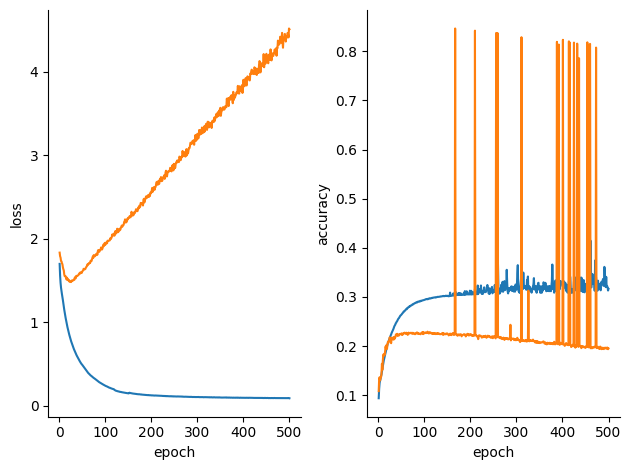

In [14]:
# plot the model accuracy and loss
perf_vals = pd.DataFrame()
perf_vals['loss'] = training_model.history.history['loss']
perf_vals['val_loss'] = training_model.history.history['val_loss']
perf_vals['accuracy'] = training_model.history.history['accuracy']
perf_vals['val_accuracy'] = training_model.history.history['val_accuracy']
perf_vals['epoch'] = range(1, len(perf_vals) + 1)

fig, axs = plt.subplots(1, 2)

sns.lineplot(x="epoch", y="loss", data=perf_vals, ax=axs[0])
sns.lineplot(x="epoch", y="val_loss", data=perf_vals, ax=axs[0])

sns.lineplot(x="epoch", y="accuracy", data=perf_vals, ax=axs[1])
sns.lineplot(x="epoch", y="val_accuracy", data=perf_vals, ax=axs[1])

plt.tight_layout()
sns.despine()

**Model Testing**

**CAUTION:** This code can take a while to run... anywhere from 20 minutes to several hours. When it is finished, the translations will appear.

In [15]:
# from preprocessing import input_features_dict, target_features_dict, reverse_input_features_dict, reverse_target_features_dict, max_decoder_seq_length, input_docs, target_docs, \
# input_tokens, target_tokens
# from training_model import encoder_inputs, decoder_inputs, encoder_states, decoder_lstm, decoder_dense, encoder_input_data, num_decoder_tokens, latent_dim

from tensorflow import keras
from keras.layers import Input, LSTM, Dense
from keras.models import Model, load_model
import numpy as np

In [16]:
# these lines of code are only necessary because we're using a saved model
training_model = load_model('training_model.h5')
encoder_inputs = training_model.input[0]
encoder_outputs, state_h_enc, state_c_enc = training_model.layers[2].output
encoder_states = [state_h_enc, state_c_enc]

# Build the encoder test model:
encoder_model = Model(encoder_inputs, encoder_states)

# this is the same value as above
latent_dim = 256
# Build the two decoder state input layers
decoder_state_input_hidden = Input(shape=(latent_dim,))
decoder_state_input_cell = Input(shape=(latent_dim,))
# Put them into a list
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]
# Call the decoder LSTM
decoder_outputs, state_hidden, state_cell = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden, state_cell]
# Redefine the decoder outputs
decoder_outputs = decoder_dense(decoder_outputs)
# Build the decoder test model
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

def decode_sequence(test_input):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(test_input)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first token of target sequence with the start token.
    target_seq[0, 0, target_features_dict['<START>']] = 1.

    # Sampling loop for a batch of sequences (to simplify, here we assume a batch of size 1).
    decoded_sentence = ''

    stop_condition = False
    while not stop_condition:
        # Run the decoder model to get possible output tokens (with probabilities) & states
        output_tokens, hidden_state, cell_state = decoder_model.predict([target_seq] + states_value)

        # Choose token with highest probability
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_features_dict[sampled_token_index]
        decoded_sentence += " " + sampled_token

        # Exit condition: either hit max length or find stop token.
        if (sampled_token == '<END>' or len(decoded_sentence) > max_decoder_seq_length):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.

        # Update states
        states_value = [hidden_state, cell_state]

    return decoded_sentence


# CHANGE RANGE (NUMBER OF TEST SENTENCES TO TRANSLATE) AS YOU PLEASE
for seq_index in range(100):
    test_input = encoder_input_data[seq_index: seq_index + 1]
    decoded_sentence = decode_sequence(test_input)
    print('-')
    print('Input sentence:', input_docs[seq_index])
    print('Decoded sentence:', decoded_sentence)

1/1 [==============================] - 0s 17ms/step
-
Input sentence: Go.
Decoded sentence:  Geh . <END>
1/1 [==============================] - 0s 18ms/step
-
Input sentence: Hi.
Decoded sentence:  Grüß Gott ! <END>
1/1 [==============================] - 0s 16ms/step
-
Input sentence: Hi.
Decoded sentence:  Grüß Gott ! <END>
1/1 [==============================] - 0s 16ms/step
-
Input sentence: Run!
Decoded sentence:  Lauf ! <END>
1/1 [==============================] - 0s 17ms/step
-
Input sentence: Run.
Decoded sentence:  Lauf ! <END>
1/1 [==============================] - 0s 16ms/step
-
Input sentence: Wow!
Decoded sentence:  Potzdonner ! <END>
1/1 [==============================] - 0s 50ms/step
-
Input sentence: Wow!
Decoded sentence:  Potzdonner ! <END>
1/1 [==============================] - 0s 32ms/step
-
Input sentence: Duck!
Decoded sentence:  Kopf runter ! <END>
1/1 [==============================] - 0s 17ms/step
-
Input sentence: Fire!
Decoded sentence:  Feuer ! <END>
1/1 [====